In [557]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/council-policy/chelsea.pdf
/kaggle/input/council-policy/redbridge.pdf
/kaggle/input/council-policy-1/hammersmith_and_fullham.pdf
/kaggle/input/agents-intensive-capstone-project/Hackathon dataset.txt
/kaggle/input/house-prices/house_pricing.xlsx


In [558]:
!pip install -Uq "google-genai==1.7.0"
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip install chromadb
!pip install fitz
!pip install mcp mcp-server

In [559]:
from google import genai
from google.genai import types

from IPython.display import Markdown, display

genai.__version__

'1.7.0'

In [560]:
from kaggle_secrets import UserSecretsClient

client = genai.Client(api_key=UserSecretsClient().get_secret("GOOGLE_API_KEY"))

In [561]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

### Session/Memory and States definitions

In [562]:
from typing import TypedDict, Optional, Dict, Annotated
from langgraph.graph import add_messages

class State(TypedDict):
    postcode: Annotated[str, add_messages]
    policy: Annotated[Optional[Dict], add_messages]  
    housing: Annotated[Optional[Dict], add_messages]
    transport: Annotated[Optional[Dict], add_messages]
    community: Annotated[Optional[Dict], add_messages]
    crime: Annotated[Optional[Dict], add_messages]
    summary: Annotated[Optional[str], add_messages]


In [563]:
class SessionMemory:
    """
    Simple in-memory session store keyed by session_id.
    Stores State objects for the duration of the session.
    """
    def __init__(self):
        self.sessions = {}

    def save(self, session_id: str, state: State):
        self.sessions[session_id] = state

    def load(self, session_id: str) -> State:
        return self.sessions.get(session_id)

    def exists(self, session_id: str) -> bool:
        return session_id in self.sessions


### Custom Helper functions/tools

In [564]:
import re
import requests

class ExternalAPI:
    INCOME_URL = "https://crystalroof.co.uk/customer-api/income/mean-household-income/postcode/v1/W60WW?api_key=DEMO"
    CRIME_URL = "https://crystalroof.co.uk/customer-api/crime/crime-rate/postcode/v1/W60WW?api_key=DEMO"
    
    def income_api(self, postcode: str):
        url = self.INCOME_URL
        try:
            resp = requests.get(url, timeout=10)
            if resp.status_code != 200:
                return None
            return resp.json()['data']['totalMeanAnnualIncome']
        except:
            return None
    
    def crime_api_tool(self, postcode: str):
        url = self.CRIME_URL
        try:
            resp = requests.get(url, timeout=10)
            return resp.json() if resp.status_code == 200 else None
        except:
            return None
api = ExternalAPI()

In [565]:
from google.genai import types

def search_google(query: str) -> dict:
    # 1. Configure grounding
    config_with_search = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
    )

    # 2. Helper to query search-grounded model
    def query_with_grounding():
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=query,
            config=config_with_search
        )
        return response.candidates[0]

    # 3. Retry until grounding chunks exist
    rc = query_with_grounding()
    while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
        rc = query_with_grounding()

    # 4. Extract grounded search results
    chunks = rc.grounding_metadata.grounding_chunks
    sources = []
    for chunk in chunks:
        title = chunk.web.title or "Unknown"
        url = chunk.web.uri or ""
        sources.append(f"{title}: {url}")
    return sources


In [566]:
import pandas as pd

def load_excel(path="/kaggle/input/house-prices/house_pricing.xlsx"):
    """Load Excel file and return the file object and sheet list (excluding first sheet)."""
    xls = pd.ExcelFile(path)
    sheets = xls.sheet_names[1:]
    return xls, sheets


def flatten_columns(df):
    """Flatten multi-index columns and remove 'Unnamed' entries."""
    df.columns = [
        "_".join([str(c) for c in col if str(c) != "nan"])
        for col in df.columns
    ]
    return df.loc[:, ~df.columns.str.contains("Unnamed")]


def parse_sheet_by_house_type(df):
    """Parse the 'By type' sheet for 2025."""
    df = df.iloc[:, :5]
    df.iloc[:, 0] = df.iloc[:, 0].ffill()

    london_2025 = df[df.iloc[:, 0] == 2025].reset_index(drop=True)
    col_names = ["Year", "Month", "Detached", "Semi Detached", "Terraced", "Flat"]
    london_2025.columns = col_names[:len(london_2025.columns)]
    return london_2025


def _parse_generic(df, value_name):
    """Shared melt-and-filter logic for multiple sheets."""
    df = df.iloc[:, :-15]

    melted = df.melt(
        id_vars=[df.columns[0]],
        var_name="Borough",
        value_name=value_name,
    )

    year_col = df.columns[0]
    melted = (
        melted[melted[year_col].astype(str).str.contains("25")]
        .reset_index(drop=True)
    )

    melted.columns = ["Year_Month", "Borough", value_name]
    return melted


def parse_average_type(df):
    return _parse_generic(df, "Average Price")


def parse_sales_volume(df):
    return _parse_generic(df, "Sales Volume")


def parse_excel(
    path="/kaggle/input/house-prices/house_pricing.xlsx",
    borough="H_a_m_m_e_r_s_m_i_t_h_ _&_ _F_u_l_h_a_m"
):
    """Parse required sheets and return (London_2025_data, borough_data)."""
    xls, sheets = load_excel(path)

    london_2025 = None
    borough_prices = None
    sales_volumes = None

    for sheet in sheets:
        df = pd.read_excel(xls, sheet_name=sheet)
        df = flatten_columns(df)

        if sheet == "By type":
            london_2025 = parse_sheet_by_house_type(df)
        elif sheet == "Average price":
            borough_prices = parse_average_type(df)
        elif sheet == "Sales Volume":
            sales_volumes = parse_sales_volume(df)

    # Merge borough-level datasets
    if borough_prices is not None and sales_volumes is not None:
        borough_data = pd.merge(
            borough_prices,
            sales_volumes,
            on=["Year_Month", "Borough"],
            how="outer",
        )
    else:
        borough_data = borough_prices or sales_volumes

    # Filter for selected borough
    if borough_data is not None:
        borough_data = borough_data[borough_data["Borough"] == borough].reset_index(drop=True)

    return london_2025, borough_data


def calculate_affordability_metric(mean_income, borough_data):
    """
    Returns (avg_house_price, affordability_metric, latest_row)
    """
    latest_row = None
    avg_house_price = None
    affordability_metric = None

    if borough_data is not None and not borough_data.empty:
        latest_row = borough_data.iloc[-1]
        avg_house_price = latest_row["Average Price"]

        # Handle objects with .text field (e.g., HTML nodes)
        if hasattr(avg_house_price, "text"):
            try:
                avg_house_price = float(avg_house_price.text)
            except:
                avg_house_price = None
        else:
            avg_house_price = float(avg_house_price)

        if avg_house_price is not None and mean_income is not None:
            affordability_metric = avg_house_price / mean_income

    return avg_house_price, affordability_metric, latest_row


In [567]:
def extract_postcode(state: State):
    latest_postcode_msg = state["postcode"][-1]  # last HumanMessage
    return latest_postcode_msg.content.strip().upper()

### Validating postcode agent

In [568]:
import re
from langchain.schema import HumanMessage

POSTCODE_RE = re.compile(r"^[A-Z]{1,2}\d[A-Z\d]?\s?\d[A-Z]{2}$")

def validate_postcode(state: State) -> State:
    postcode = extract_postcode(state)
    if not POSTCODE_RE.match(postcode):
        raise ValueError(f"Invalid postcode: {postcode}")

    state["postcode"] = [HumanMessage(content=postcode)]
    return state


### Crime API agent

In [569]:
from langchain.schema import HumanMessage

def crime_and_safety_agent(state: State) -> State:
    # Get the latest postcode string
    postcode = extract_postcode(state)
    crime_data = api.crime_api_tool(postcode)

    if not crime_data or "data" not in crime_data:
        state["crime"] = [
            HumanMessage(content=f"No crime data available for {postcode}.")
        ]
        return state

    rate = crime_data["data"].get("rate", {})
    rank = crime_data["data"].get("rank", {})

    prompt = f"""
You are a friendly assistant. Summarise the following crime data for postcode {postcode} in a concise, readable paragraph suitable for a public report. Include total crime rate, top 3 crime categories by value, and safety ranking.

Crime Rate Data:
{rate}

Crime Rank Data:
{rank}

Return the summary as natural language text.
"""

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt
    )

    natural_text_summary = response.text.strip()

    # Wrap the summary as a HumanMessage
    state["crime"] = [
        HumanMessage(content=natural_text_summary)
    ]

    return state


### Policy RAG agent

In [570]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry
import chromadb # this is a embedding function that sets up the database collection 
from google.genai import types
from pypdf import PdfReader

def load_pdf(path):
    reader = PdfReader(path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return text

pdf1 = load_pdf("/kaggle/input/council-policy-1/hammersmith_and_fullham.pdf")

def chunk(text, size=1500):
    words = text.split()
    return [" ".join(words[i:i+size]) for i in range(0, len(words), size)]

documents = chunk(pdf1)

class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"
        response = client.models.embed_content( 
            # embed_content takes the contents and converts into a vector rep and stores into a chroma (database)
            model="models/text-embedding-004",
            contents=input, # this is the document
            config=types.EmbedContentConfig(
                task_type=embedding_task,
                # tells u how the embedding should be created, 
            ),
        )
        return [e.values for e in response.embeddings]

DB_NAME = "policy_agent_db"
embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True # embedding documents first

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)
db.add(documents=documents, ids=[f"doc_{i}" for i in range(len(documents))])
print(db)

/tmp/ipykernel_47/2883762798.py:44: DeprecationWarning: The class GeminiEmbeddingFunction does not implement __init__. This will be required in a future version.
  embed_fn = GeminiEmbeddingFunction()


Collection(name=policy_agent_db)


In [571]:

def policy_agent(state: State) -> State:
    """
    Fetches local policy info and returns it as structured Markdown.
    """
    postcode = extract_postcode(state)
    
    if getattr(state, "policy", None):
        return state

    embed_fn.document_mode = False  # query mode

    question = (
        f"What planning, zoning, waste, licensing and land-use rules "
        f"apply to the area around postcode {postcode}?"
    )

    # Retrieve top 5 chunks
    results = db.query(
        query_texts=[question],
        n_results=5
    )

    retrieved_chunks = results["documents"][0]
    # Wrap chunks as Markdown bullet points
    context_md = "\n".join([f"- {chunk}" for chunk in retrieved_chunks])

    prompt = f"""
            You are CIVAI's Policy RAG Agent.
            
            Using ONLY the context below, extract all relevant policy information for the target postcode area.
            
            **User question:**
            "{question}"
            
            **Context from official policy documents:**
            {context_md}
            
            Return a **Markdown summary** with the following sections, using headings and bullets:
            
            ## 📌 Zoning Rules
            ## 🏗️ Planning Permissions
            ## ♻️ Waste & Recycling
            ## 📝 Licensing Rules
            ## 🌳 Land Use Restrictions
            ## 🏛️ Administrative / Authority Rules
            
            Make sure:
            - Each section has at least 2-3 bullet points if info exists
            - Headings are `##` for each main section
            - Bullets start with `-`
            - No extra text outside Markdown
            """

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt
    )

    state["policy"] = [
        HumanMessage(content=response.text.strip())  # Markdown summary
    ]

    return state


### Housing agent

A common metric is:

$$
\text{Affordability} \;=\; \frac{\text{House Price}}{\text{Mean Household Income}}
$$

- Lower values → more affordable.  
- Higher values → less affordable.


In [582]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def generate_affordability_plot(borough_data: pd.DataFrame, postcode: str) -> str:
    """
    Generates and saves a plot showing affordability trends for 2025.
    
    Returns the path to the saved image.
    """
    plot_path = f"plots/{postcode}_affordability.png"

    # Prepare data
    borough_data['Affordability'] = borough_data['Average Price'] / borough_data['Sales Volume']
    borough_data['Year_Month'] = pd.to_datetime(borough_data['Year_Month'], errors='coerce')
    borough_2025 = borough_data[borough_data['Year_Month'].dt.year == 2025]

    # Plot settings
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Histogram and lineplot
    sns.histplot(data=borough_2025, x='Affordability', kde=False)
    sns.lineplot(data=borough_2025, x='Year_Month', y='Affordability', marker='o')

    # Customize plot
    plt.title(f'Affordability Trend for {borough_2025["Borough"].iloc[0]} (2025)')
    plt.ylabel('Price / Mean Household Income')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.xlim(borough_2025['Year_Month'].min(), borough_2025['Year_Month'].max())

    # Save plot
    os.makedirs("plots", exist_ok=True)
    plt.savefig(plot_path, bbox_inches='tight')
    plt.close()

    return plot_path


In [573]:
def create_housing_prompt(postcode: str, avg_price: float, mean_income: float, affordability: float, london_2025_summary: str) -> str:
    """
    Creates a prompt for the AI model to generate a housing summary.
    """
    avg_price_str = f"£{avg_price}" if avg_price is not None else "N/A"
    mean_income_str = f"£{mean_income}" if mean_income is not None else "N/A"
    affordability_str = f"{affordability:.2f}" if affordability is not None else "N/A"

    return f"""
            You are a housing assistant.
            
            Provide a concise summary for postcode {postcode}:
            
            - Average house price: {avg_price_str}
            - Mean household income: {mean_income_str}
            - Affordability metric (price / income): {affordability_str}
            
            Explain if housing is affordable, moderately expensive, or expensive and compare it with {london_2025_summary} prices.
            Make it readable for a general user in 3-4 sentences.
            """

def housing_agent(state: State) -> State:
    """Generate a natural language housing summary with affordability."""
    if getattr(state, "housing_data", None):
        return state

    postcode = extract_postcode(state)
    borough = "H_a_m_m_e_r_s_m_i_t_h_ _&_ _F_u_l_h_a_m"  # or map postcode->borough

    london_2025, borough_data = parse_excel()
    mean_income = api.income_api(postcode)
    avg_house_price, affordability_metric, latest_row = calculate_affordability_metric(mean_income, borough_data)
    plot_path = generate_affordability_plot(borough_data, postcode)
    
    prompt = create_housing_prompt(postcode, avg_house_price, mean_income, affordability_metric, london_2025)
    response = client.models.generate_content(model="gemini-2.0-flash",contents=prompt)

    if hasattr(response, "text"):
        summary_text = response.text.strip()
    elif hasattr(response, "output_text"):
        summary_text = response.output_text.strip()
    elif hasattr(response, "candidates") and response.candidates:
        summary_text = response.candidates[0].content.strip()
    else:
        summary_text = "No summary generated."

    # Store in state
    state["housing"] = [
        HumanMessage(content=f"Data: avg_house_price={avg_house_price}, mean_income={mean_income}, affordability={affordability_metric}"),
        HumanMessage(content=summary_text),
        HumanMessage(content=f"![Affordability plot]({plot_path})")
    ]


    return state


### Transport 

In [574]:
from typing import Dict, Optional
from google.genai import types
from IPython.display import Markdown

def transport_agent(state: State) -> State:
    """
    Fetch transport & commute information for a given postcode
    using Google Search grounding and generate a natural language summary.
    """
    postcode = extract_postcode(state)
    
    if not postcode:
        state["transport"] = [HumanMessage(content="No postcode provided.")]
        return state

    query = f"Transport options, commute times, walkability near {postcode} London"

    sources = search_google(query)
    
    text_to_summarise = "\n".join(sources)

    # --- 5. Summarise with LLM ---
    summary_prompt = f"""
    You are a transport assistant.
    Summarise the transport options and commute information for postcode {postcode} in London.
    
    Include:
    - Nearby Tube/rail/bus stations
    - Average commute time to Central London
    - Walkability or cycling options
    
    Provide a concise, user-friendly summary in 3-4 sentences.
    
    Use the following sources to guide your summary:
    {text_to_summarise}
    """

    summary_response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=summary_prompt
    )

    state["transport"] = [
        HumanMessage(content=summary_response.text.strip())
    ]

    return state


### Community Agent

In [575]:
def community_agent(state: State) -> State:
    """
    Fetches community + amenities info around a postcode using Google Search grounding.
    Includes: parks, schools, masjids, churches, shops, restaurants, walkability.
    Produces a natural-language summary.
    """
    postcode = extract_postcode(state)
    
    if not postcode:
        state["community"] = {"summary": "No postcode provided."}
        return state

    query = f"Community amenities near {postcode} London: parks, schools, mosques, churches, shops, restaurants, walkability, family friendliness"

    sources = search_google(query)
    text_to_summarise = "\n".join(sources)

    # 5. Summarise community information
    summary_prompt = f"""
    You are a community-living expert.

    Summarise key community and lifestyle features around postcode {postcode}.

    Include:
    - Local parks and green spaces
    - Primary & secondary schools (mention Ofsted if known)
    - Mosques, churches and major places of worship
    - Nearby shops, supermarkets, cafés and restaurants
    - Walkability, safety for families, general community vibe
    - Analyse green space, air quality, walkability

    Be concise and friendly (3–5 sentences).
    Use ONLY the following search-grounded sources:

    {text_to_summarise}
    """

    summary_response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=summary_prompt
    )

    state["community"] = [
        HumanMessage(content=summary_response.text.strip())
    ]

    return state


### Summary agent

In [576]:
def summary_agent(state: State) -> State:
    """
    Builds a polished, well-structured Markdown report summarising
    the outputs of all other agents. Supports multiple HumanMessages
    per agent and ensures images appear above text.
    """

    # Extract the latest postcode string
    postcode_list = state.get("postcode", [])
    if postcode_list:
        postcode = postcode_list[-1].content
    else:
        postcode = "Unknown"

    sections = []

    # Helper to extract all content from a list of HumanMessages
    def extract_agent_content(agent_key: str) -> str:
        messages = state.get(agent_key)
        if not messages or not isinstance(messages, list):
            return ""
        # Join all messages in order
        return "\n\n".join(
            m.content for m in messages if hasattr(m, "content")
        )

    # Crime & Safety
    crime_content = extract_agent_content("crime")
    if crime_content:
        sections.append(f"## 🔒 Crime & Safety\n\n{crime_content}\n")

    # Housing
    housing_content = extract_agent_content("housing")
    if housing_content:
        sections.append(f"## 🏠 Housing Overview\n\n{housing_content}\n")

    # Transport
    transport_content = extract_agent_content("transport")
    if transport_content:
        sections.append(f"## 🚆 Transport & Connectivity\n\n{transport_content}\n")

    # Community
    community_content = extract_agent_content("community")
    if community_content:
        sections.append(f"## 🏘️ Community & Local Amenities\n\n{community_content}\n")

    # Policy / Regulations
    policy_content = extract_agent_content("policy")
    if policy_content:
        sections.append(f"## 📜 Local Policies & Regulations\n\n{policy_content}\n")

    # Final assembled report
    report = f"""
# 🏙️ CIVAI Intelligence Report
### Postcode: **{postcode}**

---

{''.join(sections)}

---

### 🧾 Report Generated Automatically by CIVAI
"""

    # Store as a single HumanMessage
    state["summary"] = [HumanMessage(content=report.strip())]

    return state


### Orchestrator agent

In [577]:
from langgraph.graph import StateGraph, END

graph = StateGraph(State)

graph.add_node("validate", validate_postcode)
graph.add_node("policy_info", policy_agent)
graph.add_node("crime_safety", crime_and_safety_agent)
graph.add_node("housing_info", housing_agent)
graph.add_node("transport_info", transport_agent)
graph.add_node("community_info", community_agent)
graph.add_node("build_summary", summary_agent)

graph.set_entry_point("validate")

# Run all agents independently after validation
graph.add_edge("validate", "policy_info")
graph.add_edge("validate", "housing_info")
graph.add_edge("validate", "crime_safety")
graph.add_edge("validate", "transport_info")
graph.add_edge("validate", "community_info")

# Then summary collects everything
graph.add_edge("policy_info", "build_summary")
graph.add_edge("housing_info", "build_summary")
graph.add_edge("transport_info", "build_summary")
graph.add_edge("community_info", "build_summary")
graph.add_edge("crime_safety", "build_summary")

graph.add_edge("build_summary", END)

app = graph.compile()
print(app)


In [578]:
def run_pipeline(postcode, session_id="default"):
    # Load or create state
    state = memory.load(session_id) or State(postcode=postcode)

    # Run LangGraph
    final_state = app.invoke(state)

    # Save session memory
    memory.save(session_id, final_state)

    return final_state

from IPython.display import Markdown, display

def render_md(state):
    """
    Render the summary in Markdown format from the state.
    Handles:
      - Plain string
      - List of HumanMessage objects (LangGraph style)
    Preserves all embedded Markdown.
    """
    summary = state.get("summary")

    # If summary is a list of HumanMessage, extract all content
    if isinstance(summary, list):
        md_text = "\n\n".join(
            m.content if hasattr(m, "content") else str(m)
            for m in summary
        )
    # If summary is a plain string
    elif isinstance(summary, str):
        md_text = summary
    else:
        md_text = str(summary)

    display(Markdown(md_text.strip()))


In [579]:
memory = SessionMemory()

state_a = run_pipeline(session_id="session_A", postcode="W60WW")
render_md(state_a)

state_b = run_pipeline(session_id="session_B", postcode="N12AB")
render_md(state_b)

# Re-run session A
state_a_repeat = run_pipeline(session_id="session_A", postcode="W60WW")
render_md(state_a_repeat)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


# 🏙️ CIVAI Intelligence Report
### Postcode: **W60WW**

---

## 🔒 Crime & Safety

The postcode W6 0WW has a total crime rate of 39.35 crimes per 1,000 residents. The most prevalent types of crime are Violence and Sexual Offences (11.57), Anti-social Behaviour (7.72), and Vehicle Crime (6.94). Overall, the area has a safety ranking of 2 (where 1 is the safest, and a higher number implies more crimes).
## 🏠 Housing Overview

Data: avg_house_price=763345.0, mean_income=66000, affordability=11.565833333333334

Okay, here's a summary for postcode W6 0WW, considering affordability and providing context based on the provided house price data:

"In W6 0WW, the average house price is £763,345, while the mean household income is £66,000. This results in an affordability metric of 11.57, indicating that housing in this area is **expensive**. Comparatively, while prices may have seen some minor fluctuations throughout 2025, you should expect to pay around £1,150,000 for a detached house, £720,000 for a semi-detached, and £640,000 for a terraced house."

![Affordability plot](plots/W60WW_affordability.png)
## 🚆 Transport & Connectivity

W6 0WW is located in White City, with convenient access to transport options. The area is well-served by White City and Wood Lane tube stations (Central and Hammersmith & City lines), and several bus routes. Commuting to Central London takes approximately 30-45 minutes by tube. The area is also considered walkable and offers cycling routes, making it easy to get around locally.
## 🏘️ Community & Local Amenities

W6 0WW sits in Hammersmith, offering a vibrant community feel. You'll find several parks and green spaces nearby, including Ravenscourt Park, providing ample outdoor opportunities. For families, there are primary and secondary schools in the area, as well as churches and a mosque. With plenty of shops, cafes and restaurants and a "very walkable" Walk Score, it's a conveniently located and family-friendly neighbourhood.
## 📜 Local Policies & Regulations

## 📌 Zoning Rules
*(No information about zoning rules for W60WW in context provided)*

## 🏗️ Planning Permissions
- Contact the Duty Planner Advice Service for planning permission advice - LBHF Duty Planner Advice Service and LBHF Planning Applications Webpage

## ♻️ Waste & Recycling
- Commercial waste: 020 8753 3021, cleaner.greener@lbhf.gov.uk, LBHF Commercial Waste Webpage
- Businesses can increase or decrease their collection service every three months by calling the trade waste team on 020 8 753 3021, or alternatively email them on tradewasteemails@lbhf.gov.uk.
- Licensed waste carriers operating within the Borough are listed on the council website.
- Consider how and where waste will be stored/disposed of, particularly glass and cans, to avoid noise complaints from neighbors

## 📝 Licensing Rules
- Contact the Licensing Authority: Phone: 020 8753 1081, Email: licensing@lbhf.gov.uk, Website: www.lbhf.gov.uk or write to: London Borough of Hammersmith & Fulham Licensing Authority King Street, London, W6 9JU
- Licensing Authority issues licenses for people working in the private security business, including door supervisors.
- The SOLP outlines strategic aims and identifies health aims
- Clear measures should promote each of the four licensing objectives: Crime and Disorder, Public Safety, Public Nuisance, and Protection of Children from harm.
- Licensing policy gives guidance on licensing hours and the requirements for a Temporary Event Notice (TEN).
- Late night takeaways should assess the risk of persons congregating and demonstrate measures to address this.
- Enforcement will be focused on premises or persons failing to promote the four Licensing Objectives.
- Applicants are expected to undertake a local area risk assessment as part of any licensing application

## 🌳 Land Use Restrictions
- Applicants are expected to understand the layout of the local area and physical environment
- The provision for public transport in the locality for patrons should be considered.
- The level of likely disturbance from associated vehicular and pedestrian movement to and from the premises should be considered.
- Applicants should consider the effect of parking by patrons on local residents.

## 🏛️ Administrative / Authority Rules
- Contact the Licensing Team on 020 8753 1081 or by email at licensing@lbhf.gov.uk for breaches of conditions
- Complaints about noise nuisance should be brought to the attention of the Noise and Nuisance team on 020 8753 1081 during office hours and 020 8748 8588 at all other times.
- Enforcement will be focused on premises or persons failing to promote the four Licensing Objectives.
- The Licensing Authority is committed to supporting well-run licensed premises and will ensure that there are not unreasonably limited in running their businesses by the requirements of the licensing regime.


---

### 🧾 Report Generated Automatically by CIVAI

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


# 🏙️ CIVAI Intelligence Report
### Postcode: **N12AB**

---

## 🔒 Crime & Safety

The postcode N12AB has a total crime rate of 39.35 crimes per 1,000 residents, placing it at safety rank 2, with 1 being safest and higher numbers indicating higher crime rates. The most prevalent crimes are violence and sexual offences (11.57), anti-social behaviour (7.72), and vehicle crime (6.94).
## 🏠 Housing Overview

Data: avg_house_price=763345.0, mean_income=66000, affordability=11.565833333333334

Okay, here's a summary for postcode N12AB:

The average house price in N12AB is £763,345, while the mean household income is £66,000. This gives an affordability metric of 11.57, meaning housing in N12AB is considered **expensive**. Compared to predicted average house prices in 2025, N12AB appears more affordable for detached properties.

![Affordability plot](plots/N12AB_affordability.png)
## 🚆 Transport & Connectivity

N12AB (North Finchley) offers good transport links. Nearby stations include Woodside Park and Totteridge & Whetstone tube stations (Northern Line) and numerous bus routes. Commute time to Central London is typically around 30-45 minutes by tube. The area also offers decent walkability and cycling options.
## 🏘️ Community & Local Amenities

N1 2AB is located in Islington, known for its vibrant community and convenient access to amenities. The area benefits from green spaces and decent walkability. You'll find a mix of shops, cafes, and restaurants nearby, contributing to a lively local atmosphere. For families, there are schools and various places of worship, including mosques and churches, fostering a welcoming environment for all.
## 📜 Local Policies & Regulations

## 📌 Zoning Rules
(No direct zoning rules mentioned in the provided context)

## 🏗️ Planning Permissions
(No direct planning permission rules mentioned in the provided context)

## ♻️ Waste & Recycling
- Arrangements for refuse disposal, storage, and prevention/tidying of litter are considered.
- Deliveries/collections (e.g. refuse) from the premises are a common source of complaint. Noise and Nuisance Service recommend that deliveries/collections should only be made between the hours of 7:30am and 9:00pm, depending on the proximity of residential and/or other noise- sensitive properties.
- How and where waste will be stored/disposed of at the end of trading hours. Disposal of glass and/or cans to outside bin areas can be very noisy.
- Commercial waste can be taken to council-approved waste transfer sites, or licensed waste carriers can be used. A flexible commercial waste service is offered by the Council. Contact the trade waste team on 020 8 753 3021 or tradewasteemails@lbhf.gov.uk.
- Minimising food waste and stopping the use of single-use plastics are welcome green initiatives.

## 📝 Licensing Rules
- The Licensing Authority considers factors such as the history of previous nuisance complaints against the premises, the applicant's history in controlling anti-social behavior and preventing nuisance, and representations made by the Police.
- Deliveries/collections noise from deliveries/collections (e.g. refuse) from the premises are a common source of complaint. Consider the times of such deliveries/collections and make sure you specify to any contractors that deliveries/collections should not be made at anti-social times.
- Late night refreshment - applicants in respect of late night takeaways should demonstrate that they have assessed the risk of persons congregating in large numbers in the vicinity of their premises. Where appropriate, applicants should demonstrate suitable measures to address this problem.
- Illuminated signs should not cause glare to neighbouring properties, ideally being turned off at night, and external lighting should be angled and/or diffused to also prevent nuisance.
- Queue management - establishing appropriate procedures to avoid the need for customers to queue before entering the premises or, where queuing cannot be avoided, to manage queues so as to minimise the potential for crime and disorder or public nuisance by customers who are queuing.
- Enforcement will be focused on premises or persons found to be failing to promote the four Licensing Objectives.
- Complaints about breaches of conditions e.g. trading after the hours stated on the licence, should be brought to the attention of the Licensing Team on 020 8753 1081 or by email at licensing@lbhf.gov.uk.
- The Licensing Authority expects that any licence applicant will give due consideration to the needs of Hammersmith & Fulham residents and any negative impacts from licensable activities and business operations.

## 🌳 Land Use Restrictions
- (No direct land-use restrictions mentioned in the provided context, but proximity to residential properties is a major consideration in licensing decisions)

## 🏛️ Administrative / Authority Rules
- The Licensing Authority operates a reactive and proactive inspection regime based on risk and specific incidents.
- The Licensing Authority will follow principles and approaches outlined in the policy where complaints or representations are made and where reviews are initiated.
- Licensing Authority may carry out targeted consultation in the local area where there has been a history of disorder, threatening public safety, generating public nuisance or threatening the well-being of children and vulnerable people.
- The Licensing Authority is committed to supporting well-run licensed premises and will ensure that they are not unreasonably limited in running their businesses.
- Contact the Licensing Authority for further information: Phone: 020 8753 1081 Email: licensing@lbhf.gov.uk Website: www.lbhf.gov.uk or write to: London Borough of Hammersmith & Fulham Licensing Authority King Street, London, W6 9JU


---

### 🧾 Report Generated Automatically by CIVAI

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


# 🏙️ CIVAI Intelligence Report
### Postcode: **W60WW**

---

## 🔒 Crime & Safety

The postcode W6 0WW has a total crime rate of 39.35 crimes per 1,000 residents. The most prevalent types of crime are Violence and Sexual Offences (11.57), Anti-social Behaviour (7.72), and Vehicle Crime (6.94). Overall, the area has a safety ranking of 2 (where 1 is the safest, and a higher number implies more crimes).
## 🏠 Housing Overview

Data: avg_house_price=763345.0, mean_income=66000, affordability=11.565833333333334

Okay, here's a summary for postcode W6 0WW, considering affordability and providing context based on the provided house price data:

"In W6 0WW, the average house price is £763,345, while the mean household income is £66,000. This results in an affordability metric of 11.57, indicating that housing in this area is **expensive**. Comparatively, while prices may have seen some minor fluctuations throughout 2025, you should expect to pay around £1,150,000 for a detached house, £720,000 for a semi-detached, and £640,000 for a terraced house."

![Affordability plot](plots/W60WW_affordability.png)
## 🚆 Transport & Connectivity

W6 0WW is located in White City, with convenient access to transport options. The area is well-served by White City and Wood Lane tube stations (Central and Hammersmith & City lines), and several bus routes. Commuting to Central London takes approximately 30-45 minutes by tube. The area is also considered walkable and offers cycling routes, making it easy to get around locally.
## 🏘️ Community & Local Amenities

W6 0WW sits in Hammersmith, offering a vibrant community feel. You'll find several parks and green spaces nearby, including Ravenscourt Park, providing ample outdoor opportunities. For families, there are primary and secondary schools in the area, as well as churches and a mosque. With plenty of shops, cafes and restaurants and a "very walkable" Walk Score, it's a conveniently located and family-friendly neighbourhood.
## 📜 Local Policies & Regulations

## 📌 Zoning Rules
*(No information about zoning rules for W60WW in context provided)*

## 🏗️ Planning Permissions
- Contact the Duty Planner Advice Service for planning permission advice - LBHF Duty Planner Advice Service and LBHF Planning Applications Webpage

## ♻️ Waste & Recycling
- Commercial waste: 020 8753 3021, cleaner.greener@lbhf.gov.uk, LBHF Commercial Waste Webpage
- Businesses can increase or decrease their collection service every three months by calling the trade waste team on 020 8 753 3021, or alternatively email them on tradewasteemails@lbhf.gov.uk.
- Licensed waste carriers operating within the Borough are listed on the council website.
- Consider how and where waste will be stored/disposed of, particularly glass and cans, to avoid noise complaints from neighbors

## 📝 Licensing Rules
- Contact the Licensing Authority: Phone: 020 8753 1081, Email: licensing@lbhf.gov.uk, Website: www.lbhf.gov.uk or write to: London Borough of Hammersmith & Fulham Licensing Authority King Street, London, W6 9JU
- Licensing Authority issues licenses for people working in the private security business, including door supervisors.
- The SOLP outlines strategic aims and identifies health aims
- Clear measures should promote each of the four licensing objectives: Crime and Disorder, Public Safety, Public Nuisance, and Protection of Children from harm.
- Licensing policy gives guidance on licensing hours and the requirements for a Temporary Event Notice (TEN).
- Late night takeaways should assess the risk of persons congregating and demonstrate measures to address this.
- Enforcement will be focused on premises or persons failing to promote the four Licensing Objectives.
- Applicants are expected to undertake a local area risk assessment as part of any licensing application

## 🌳 Land Use Restrictions
- Applicants are expected to understand the layout of the local area and physical environment
- The provision for public transport in the locality for patrons should be considered.
- The level of likely disturbance from associated vehicular and pedestrian movement to and from the premises should be considered.
- Applicants should consider the effect of parking by patrons on local residents.

## 🏛️ Administrative / Authority Rules
- Contact the Licensing Team on 020 8753 1081 or by email at licensing@lbhf.gov.uk for breaches of conditions
- Complaints about noise nuisance should be brought to the attention of the Noise and Nuisance team on 020 8753 1081 during office hours and 020 8748 8588 at all other times.
- Enforcement will be focused on premises or persons failing to promote the four Licensing Objectives.
- The Licensing Authority is committed to supporting well-run licensed premises and will ensure that there are not unreasonably limited in running their businesses by the requirements of the licensing regime.


---

### 🧾 Report Generated Automatically by CIVAI

# 🏙️ CIVAI Intelligence Report
### Postcode: **W60WW**

---

## 🔒 Crime & Safety

The postcode W6 0WW has a total crime rate of 39.35 crimes per 1,000 residents. The most prevalent types of crime are Violence and Sexual Offences (11.57), Anti-social Behaviour (7.72), and Vehicle Crime (6.94). Overall, the area has a safety ranking of 2 (where 1 is the safest, and a higher number implies more crimes).

The postcode W6 0WW has a total crime rate of 39.35 crimes per 1000 residents, ranking it as the 2nd safest area compared to others in the dataset. The most prevalent crime categories are Violence and sexual offences (11.57), Anti-social behaviour (7.72), and Vehicle crime (6.94).
## 🏠 Housing Overview

Data: avg_house_price=763345.0, mean_income=66000, affordability=11.565833333333334

Okay, here's a summary for postcode W6 0WW, considering affordability and providing context based on the provided house price data:

"In W6 0WW, the average house price is £763,345, while the mean household income is £66,000. This results in an affordability metric of 11.57, indicating that housing in this area is **expensive**. Comparatively, while prices may have seen some minor fluctuations throughout 2025, you should expect to pay around £1,150,000 for a detached house, £720,000 for a semi-detached, and £640,000 for a terraced house."

![Affordability plot](plots/W60WW_affordability.png)

Data: avg_house_price=763345.0, mean_income=66000, affordability=11.565833333333334

Here's a summary of housing in the W6 0WW postcode:

The average house price in W6 0WW is £763,345, while the mean household income is £66,000. This gives an affordability metric of 11.57, which indicates that housing in this area is **expensive**. Compared to 2025 data detached houses are more expensive, semi-detached and terraced houses are cheaper.

![Affordability plot](plots/W60WW_affordability.png)
## 🚆 Transport & Connectivity

W6 0WW is located in White City, with convenient access to transport options. The area is well-served by White City and Wood Lane tube stations (Central and Hammersmith & City lines), and several bus routes. Commuting to Central London takes approximately 30-45 minutes by tube. The area is also considered walkable and offers cycling routes, making it easy to get around locally.

W6 0WW is located in White City, London, with several transport options. The nearest tube stations include White City (Central Line) and Wood Lane (Hammersmith & City Line). Average commute time to Central London is around 30-40 minutes by tube. The area is also relatively walkable and offers cycling routes, promoting alternative transportation.
## 🏘️ Community & Local Amenities

W6 0WW sits in Hammersmith, offering a vibrant community feel. You'll find several parks and green spaces nearby, including Ravenscourt Park, providing ample outdoor opportunities. For families, there are primary and secondary schools in the area, as well as churches and a mosque. With plenty of shops, cafes and restaurants and a "very walkable" Walk Score, it's a conveniently located and family-friendly neighbourhood.

W6 0WW, in Hammersmith & Fulham, offers a vibrant community with a blend of green spaces and urban conveniences. Residents enjoy access to local parks, benefiting from green space and decent air quality. The area boasts a selection of shops, cafes, and restaurants, contributing to a lively atmosphere. With good walkability and access to local primary and secondary schools, it’s considered a safe and family-friendly environment.
## 📜 Local Policies & Regulations

## 📌 Zoning Rules
*(No information about zoning rules for W60WW in context provided)*

## 🏗️ Planning Permissions
- Contact the Duty Planner Advice Service for planning permission advice - LBHF Duty Planner Advice Service and LBHF Planning Applications Webpage

## ♻️ Waste & Recycling
- Commercial waste: 020 8753 3021, cleaner.greener@lbhf.gov.uk, LBHF Commercial Waste Webpage
- Businesses can increase or decrease their collection service every three months by calling the trade waste team on 020 8 753 3021, or alternatively email them on tradewasteemails@lbhf.gov.uk.
- Licensed waste carriers operating within the Borough are listed on the council website.
- Consider how and where waste will be stored/disposed of, particularly glass and cans, to avoid noise complaints from neighbors

## 📝 Licensing Rules
- Contact the Licensing Authority: Phone: 020 8753 1081, Email: licensing@lbhf.gov.uk, Website: www.lbhf.gov.uk or write to: London Borough of Hammersmith & Fulham Licensing Authority King Street, London, W6 9JU
- Licensing Authority issues licenses for people working in the private security business, including door supervisors.
- The SOLP outlines strategic aims and identifies health aims
- Clear measures should promote each of the four licensing objectives: Crime and Disorder, Public Safety, Public Nuisance, and Protection of Children from harm.
- Licensing policy gives guidance on licensing hours and the requirements for a Temporary Event Notice (TEN).
- Late night takeaways should assess the risk of persons congregating and demonstrate measures to address this.
- Enforcement will be focused on premises or persons failing to promote the four Licensing Objectives.
- Applicants are expected to undertake a local area risk assessment as part of any licensing application

## 🌳 Land Use Restrictions
- Applicants are expected to understand the layout of the local area and physical environment
- The provision for public transport in the locality for patrons should be considered.
- The level of likely disturbance from associated vehicular and pedestrian movement to and from the premises should be considered.
- Applicants should consider the effect of parking by patrons on local residents.

## 🏛️ Administrative / Authority Rules
- Contact the Licensing Team on 020 8753 1081 or by email at licensing@lbhf.gov.uk for breaches of conditions
- Complaints about noise nuisance should be brought to the attention of the Noise and Nuisance team on 020 8753 1081 during office hours and 020 8748 8588 at all other times.
- Enforcement will be focused on premises or persons failing to promote the four Licensing Objectives.
- The Licensing Authority is committed to supporting well-run licensed premises and will ensure that there are not unreasonably limited in running their businesses by the requirements of the licensing regime.

```markdown
## 📌 Zoning Rules
There is no information about zoning rules in the context.

## 🏗️ Planning Permissions
There is no information about planning permissions in the context.

## ♻️ Waste & Recycling
- Arrangements for refuse disposal, storage and the prevention/tidying of litter (including fly posters and illegal placards) must be considered.
- Noise from refuse collections from premises is a common source of complaint, collections should only be made between 7:30am and 9:00pm depending on the proximity of residential and/or other noise-sensitive properties.
- Consider how and where waste will be stored/disposed of at the end of trading hours.
- Commercial waste can be taken to council approved waste transfer sites, or by licensed waste carriers. Businesses can contact the trade waste team on 020 8 753 3021 or tradewasteemails@lbhf.gov.uk to revise their contract.

## 📝 Licensing Rules
- Licensing is approached with a view to encouraging all forms of licensable activity that are carried out in ways consistent with the four Licensing Objectives.
- Licensing policy is designed to maintain a dynamic, innovative and attractive place to live, work and relax, to support businesses to be resilient and for residents to be well served and not unduly disturbed.
- Licensing Authority contact details: Phone: 020 8753 1081 Email: licensing@lbhf.gov.uk Website: www.lbhf.gov.uk
- The Private Security Industry Act 2001 manages the licensing of people working in the private security business, including door supervisors.
- Licensees are expected to minimize the impact of their activities and anti-social behaviour by their patrons within the vicinity of their premises.
- Licence holders should note that in the event of a failure to pay the annual licence fee this Authority will suspend the licence in accordance with section 55A Licensing Act 2003.

## 🌳 Land Use Restrictions
- Applicants are expected to undertake a local area risk assessment as part of any licensing application.
- Applicants are expected to obtain sufficient information to demonstrate the steps they propose to take to promote the licensing objectives; and that they understand the layout of the local area and physical environment.
- Noise and nuisance can be reported on 020 8753 1081 during office hours and 020 8748 8588 at all other times.

## 🏛️ Administrative / Authority Rules
- The Licensing Authority will work with businesses to provide advice needed to comply with the law.
- Complaints about breaches of conditions should be brought to the attention of the Licensing Team on 020 8753 1081 or licensing@lbhf.gov.uk.
- The Licensing Authority will follow the principles and approaches outlined in complaints, representations and reviews.
- The Licensing Authority is committed to supporting well-run licensed premises.
- It is easier for well-run local businesses to operate by having a clear, fair and accessible licensing process and system.
```


---

### 🧾 Report Generated Automatically by CIVAI

### Visualise graph structure

In [580]:
!apt-get install graphviz -y
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 165 not upgraded.


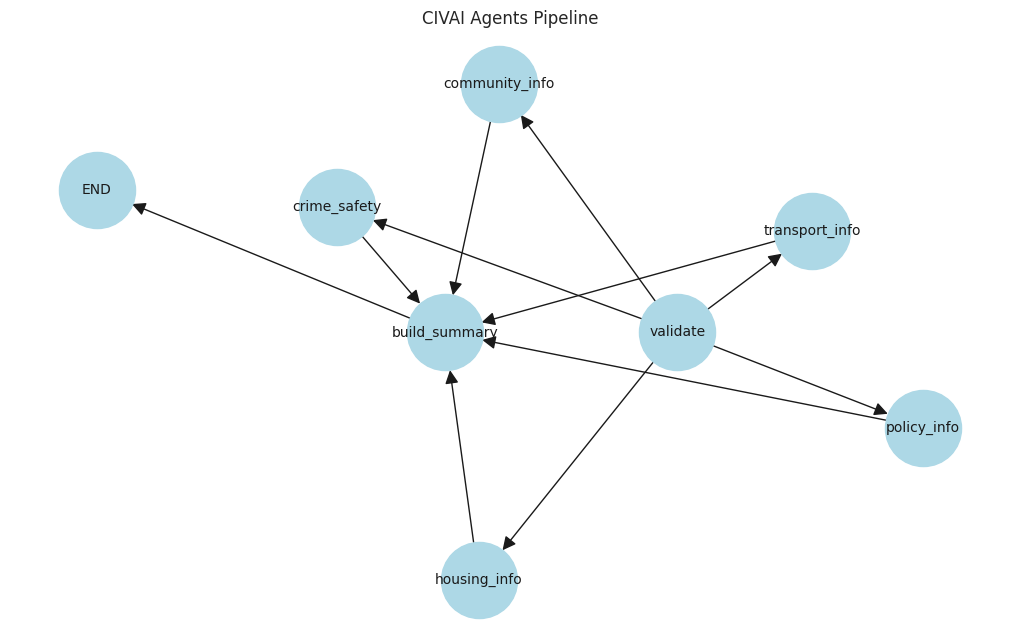

In [581]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ["validate", "policy_info", "housing_info", "crime_safety",
         "transport_info", "community_info", "build_summary", "END"]
G.add_nodes_from(nodes)

# Add edges
edges = [
    ("validate", "policy_info"),
    ("validate", "housing_info"),
    ("validate", "crime_safety"),
    ("validate", "transport_info"),
    ("validate", "community_info"),
    
    ("policy_info", "build_summary"),
    ("housing_info", "build_summary"),
    ("crime_safety", "build_summary"),
    ("transport_info", "build_summary"),
    ("community_info", "build_summary"),
    
    ("build_summary", "END")
]
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, seed=42)  # layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, arrowsize=20, font_size=10)
plt.title("CIVAI Agents Pipeline")
plt.show()
